In [ ]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

# Example LSTM model
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize and train your model
input_size = 10
hidden_size = 20
num_layers = 2
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define model parameters
input_size = 10
sequence_length = 3000
batch_size = 4

# Create a sample input tensor
sample_input = torch.randn(batch_size, sequence_length, input_size)

# Initialize the LSTM model
hidden_size = 20
num_layers = 2
output_size = 1

# Get the model's output for the sample input
model.eval()  # Set to evaluation mode
with torch.no_grad():
    sample_output = model(sample_input)

# Display sample input and output
sample_input, sample_output
print(sample_input.shape)
print(sample_output.shape)

# # Dummy input for tracing
# example_input = torch.rand(1, 5, input_size)

# # Convert to TorchScript
# traced_script_module = torch.jit.trace(model, example_input)

# # Optimize for mobile
# optimized_traced_model = optimize_for_mobile(traced_script_module)

# # Save the optimized model
# optimized_traced_model._save_for_lite_interpreter("optimized_lstm_model.ptl")


torch.Size([4, 5, 10])
torch.Size([4, 1])


#### Dataloader test

In [11]:
def test_channel_dataset():
    import h5py
    import numpy as np
    import matplotlib.pyplot as plt
    from dataloader import ChannelDataset

    filename = '/Users/muahmed/Desktop/Globecom 2025/nas-wireless/dataset/outputs/umi_compact_conf_8tx_2rx.mat'
    with h5py.File(filename, "r") as f:
        print("Top-level keys:", list(f.keys()))
        ds = f["channel_matrix"]
        print("channel_matrix dataset shape:", ds.shape)
        print("channel_matrix dataset dtype:", ds.dtype)

        # Check if dataset has compound dtype (typical for MATLAB complex arrays)
        if ds.dtype.fields is not None and "real" in ds.dtype.fields and "imag" in ds.dtype.fields:
            arr = ds[...]
            real_data = arr["real"]
            imag_data = arr["imag"]
            channel_matrix = real_data + 1j * imag_data
        else:
            # If it's not a compound dataset with 'real'/'imag', try direct conversion
            # (will fail if dtype=void or structured differently)
            channel_matrix = np.array(ds)
            if np.issubdtype(channel_matrix.dtype, np.void):
                raise TypeError("channel_matrix has a void/structured dtype and cannot be directly converted.")

    print("channel_matrix shape:", channel_matrix.shape)
    print("Channel matrix real data", real_data.shape) 
    print("Channel matrix imag data", imag_data.shape)
    print("channel_matrix dtype:", channel_matrix.dtype)
    dataset = ChannelDataset(channel_matrix)
    print(f"Dataset created with {len(dataset)} samples")
    print(f"Number of users: {dataset.num_users}")
    print(f"Time samples per user: {dataset.time_length}")


    return dataset

if __name__ == "__main__":
    test_channel_dataset()


Top-level keys: ['#refs#', 'channel_matrix', 'config']
channel_matrix dataset shape: (256, 2, 18, 8, 3000)
channel_matrix dataset dtype: [('real', '<f8'), ('imag', '<f8')]
channel_matrix shape: (256, 2, 18, 8, 3000)
Channel matrix real data (256, 2, 18, 8, 3000)
Channel matrix imag data (256, 2, 18, 8, 3000)
channel_matrix dtype: complex128
Dataset created with 767744 samples
Number of users: 256
Time samples per user: 3000


In [4]:
import h5py
import numpy as np

# Define the file path
filename = "/Users/muahmed/Desktop/Globecom 2025/nas-wireless/dataset/outputs/umi_dense_conf_8tx_2rx.mat"

# Open the .mat file and extract the channel matrix
with h5py.File(filename, "r") as f:
    channel_group = f["channel_matrix"]
    real_data = np.array(channel_group["real"])  # Extract real part
    imag_data = np.array(channel_group["imag"])  # Extract imaginary part
    channel_matrix = real_data + 1j * imag_data  # Form complex matrix

# Print the shape to confirm
print("Channel Matrix Shape:", channel_matrix.shape)

# Save the NumPy array to a .npy file
np.save("umi_dense_conf_8tx_2rx.mat", channel_matrix)




Channel Matrix Shape: (256, 2, 18, 8, 3000)


In [ ]:
# Load it back to verify
loaded_channel_matrix = np.load("/Users/muahmed/Desktop/Globecom 2025/nas-wireless/baseline models/umi_compact_conf_8tx_2rx.mat.npy")
print("Loaded Channel Matrix Shape:", loaded_channel_matrix.shape)

Loaded Channel Matrix Shape: (256, 2, 18, 16, 3000)


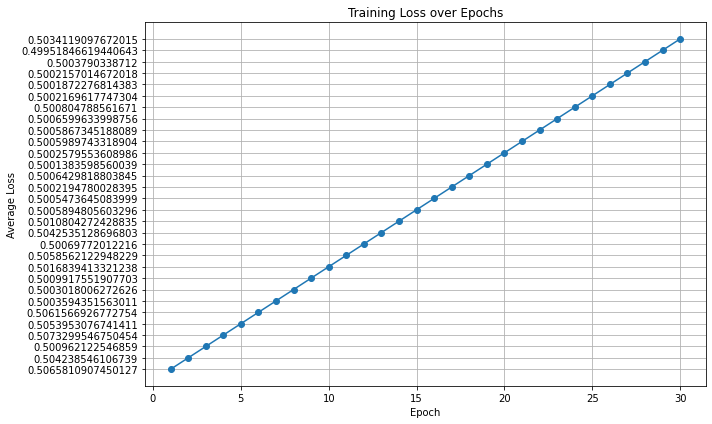

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data
data = pd.read_csv("./umi_compact_conf_2tx_2rx./training_log.csv")

# Drop the row with Total Training Time (non-numeric epoch)
data = data[pd.to_numeric(data["Epoch"], errors="coerce").notnull()]
data["Epoch"] = data["Epoch"].astype(int)

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(data["Epoch"], data["Average Loss"], marker='o', linestyle='-')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import scipy

mat = scipy.io.loadmat('H2.mat')

print(mat.keys())
print(mat['H'])
print(mat['H'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'H'])
[[-1.90675843 -0.65836453 -1.91237915 ...  0.55424827  0.98715925
   0.5527572 ]]
(1, 2688000)


In [1]:
import torch
import torch.nn as nn

# Your BinaryStep classes
class BinaryStepFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

class BinaryStep(nn.Module):
    def forward(self, x):
        return BinaryStepFunction.apply(x)

# 1) Direct usage on a tensor
x = torch.tensor([-2.0, -0.1, 0.0, 0.3, 5.0])
step = BinaryStep()
y = step(x)
print(y)  

tensor([0., 0., 0., 1., 1.])


In [2]:
import pandas as pd
import numpy as np

# 1. Load the CSV (adjust the filename/path as needed)
df = pd.read_csv("./results/masked_nmse.csv")

# 2. Compute the Masked NMSE in dB
df['Masked NMSE (dB)'] = -10 * np.log10(df['Masked NMSE'])

df.to_csv('./results/masked_nmse_db.csv', index=False)

# 4. (Optional) Inspect the first few rows
print(df.head())


  Scenario  SNR  Masked NMSE  Masked NMSE (dB)
0  Compact    0     0.000695         31.577577
1  Compact    5     0.000650         31.871984
2  Compact   10     0.000636         31.964254
3  Compact   12     0.000634         31.978888
4  Compact   14     0.000633         31.986517
